In [9]:
#!/usr/bin/env python3
import random
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils as vutils


# ---------------------------
# Utilities
# ---------------------------
def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")


def set_seed(seed: int):
    random.seed(seed)
    torch.manual_seed(seed)


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# ---------------------------
# Models
# ---------------------------
class Generator(nn.Module):
    # Outputs 28x28 from latent z of size nz
    def __init__(self, *, nz: int = 100, ngf: int = 64, nc: int = 1):
        super().__init__()
        self.main = nn.Sequential(
            # z -> 512x7x7
            nn.ConvTranspose2d(nz, ngf * 8, 7, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # 512x7x7 -> 256x14x14
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # 256x14x14 -> 128x28x28
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # 128x28x28 -> nc x 28x28
            nn.ConvTranspose2d(ngf * 2, nc, 3, 1, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        print("forward")
        return self.main(z)


class Discriminator(nn.Module):
    # Returns a single logit per image
    def __init__(self, *, nc: int = 1, ndf: int = 64):
        super().__init__()
        self.main = nn.Sequential(
            # 28x28 -> 14x14
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # 14x14 -> 7x7
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # 7x7 -> 1x1 (logit channel)
            nn.Conv2d(ndf * 2, 1, 7, 1, 0, bias=False),
            # No Sigmoid (we use BCEWithLogitsLoss)
        )

    def forward(self, x):
        out = self.main(x)          # [B,1,1,1]
        return out.view(-1, 1)      # [B,1]



In [ ]:
seed = 888
nc=1
nz=100
ngf = 64
batch_size = 10

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

data_root = "/workspaces/cosc470/data"

set_seed(seed)
device = get_device()
print(f"Device: {device}")
print(f"Using nc={nc}, nz={nz}, ngf={ngf}, ndf={ndf}")

# Data
tfm = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,)),  # scale to [-1, 1]
])
dataset = datasets.MNIST(root=data_root, train=True, download=True, transform=tfm)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=False)

# Models
netG = Generator(nz=nz, ngf=ngf, nc=nc).to(device)
netD = Discriminator(nc=nc, ndf=ndf).to(device)
netG.apply(weights_init)
netD.apply(weights_init)

print(netG)
print(netD)

# Quick sanity on shapes
with torch.no_grad():
    z = torch.randn(4, nz, 1, 1, device=device)
    fake = netG(z)
    assert fake.shape == (4, nc, 28, 28), f"G output shape wrong: {fake.shape}"
    x = torch.randn(4, nc, 28, 28, device=device)
    y = netD(x)
    assert y.shape == (4, 1), f"D output shape wrong: {y.shape}"
    print("Sanity checks passed.")

# Loss & Optims
criterion = nn.BCEWithLogitsLoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [11]:

# Fixed noise for monitoring
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Output dir
out_dir = Path("samples")
out_dir.mkdir(parents=True, exist_ok=True)

# Labels (shape [B,1])
real_label = 1.0
fake_label = 0.0

print("Starting Training Loop...")
for epoch in range(1, epochs + 1):
    for i, (real, _) in enumerate(dataloader, start=1):
        bsz = real.size(0)
        real = real.to(device, non_blocking=True)

        # -----------------
        # Train Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        # -----------------
        netD.zero_grad(set_to_none=True)

        labels_real = torch.full((bsz, 1), real_label, device=device, dtype=torch.float32)
        out_real = netD(real)                  # [B,1]
        lossD_real = criterion(out_real, labels_real)
        lossD_real.backward()

        noise = torch.randn(bsz, nz, 1, 1, device=device)
        fake = netG(noise)                     # [B,1,28,28]
        labels_fake = torch.full((bsz, 1), fake_label, device=device, dtype=torch.float32)
        out_fake = netD(fake.detach())         # [B,1]
        lossD_fake = criterion(out_fake, labels_fake)
        lossD_fake.backward()

        optimizerD.step()
        lossD = lossD_real + lossD_fake

        # -----------------
        # Train Generator: maximize log(D(G(z)))  (i.e., fool D to think fakes are real)
        # -----------------
        netG.zero_grad(set_to_none=True)
        labels_gen = torch.full((bsz, 1), real_label, device=device, dtype=torch.float32)
        out_fake_for_G = netD(fake)            # recompute; do not detach
        lossG = criterion(out_fake_for_G, labels_gen)
        lossG.backward()
        optimizerG.step()

        if i % 100 == 0:
            print(f"[{epoch}/{epochs}][{i}/{len(dataloader)}] "
                    f"Loss_D: {lossD.item():.4f} (R {lossD_real.item():.4f} F {lossD_fake.item():.4f}) "
                    f"Loss_G: {lossG.item():.4f}")

    # Save a grid each epoch
    with torch.no_grad():
        fake_fixed = netG(fixed_noise).cpu()
    grid = vutils.make_grid(fake_fixed, padding=2, normalize=True, nrow=8)
    vutils.save_image(grid, out_dir / f"epoch_{epoch:03d}.png")


Starting Training Loop...
[1/10][100/6000] Loss_D: 1.0419 (R 0.5975 F 0.4443) Loss_G: 1.0590
[1/10][200/6000] Loss_D: 1.3343 (R 0.8783 F 0.4560) Loss_G: 0.9857
[1/10][300/6000] Loss_D: 1.3431 (R 0.6130 F 0.7302) Loss_G: 1.1688
[1/10][400/6000] Loss_D: 1.3284 (R 0.6827 F 0.6457) Loss_G: 0.9725
[1/10][500/6000] Loss_D: 1.2379 (R 0.5759 F 0.6620) Loss_G: 0.8616
[1/10][600/6000] Loss_D: 1.2589 (R 0.6731 F 0.5857) Loss_G: 1.2272
[1/10][700/6000] Loss_D: 1.4340 (R 0.7019 F 0.7321) Loss_G: 0.8875
[1/10][800/6000] Loss_D: 1.2854 (R 0.9072 F 0.3781) Loss_G: 1.2174
[1/10][900/6000] Loss_D: 1.0652 (R 0.6541 F 0.4111) Loss_G: 1.3797
[1/10][1000/6000] Loss_D: 1.4201 (R 0.8010 F 0.6191) Loss_G: 0.8394
[1/10][1100/6000] Loss_D: 1.4974 (R 1.0915 F 0.4059) Loss_G: 0.6887
[1/10][1200/6000] Loss_D: 1.4059 (R 0.8743 F 0.5317) Loss_G: 0.9865
[1/10][1300/6000] Loss_D: 0.8867 (R 0.4121 F 0.4747) Loss_G: 1.1641
[1/10][1400/6000] Loss_D: 1.0480 (R 0.3365 F 0.7115) Loss_G: 1.1371
[1/10][1500/6000] Loss_D: 1.296

KeyboardInterrupt: 

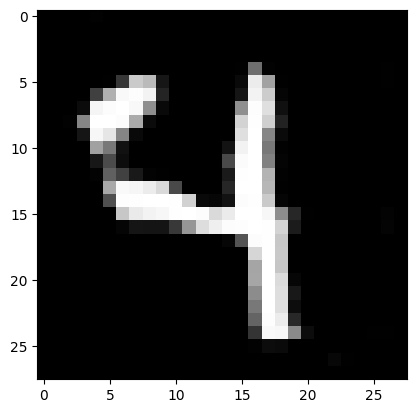

Done. Samples saved to: C:\Users\brtoone\python\cosc470-kartoone76\cosc470\notebooks\samples


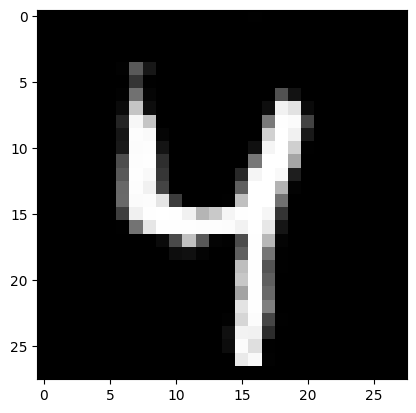

In [50]:
# Final sample
import matplotlib.pyplot as plt
with torch.no_grad():
    set_seed(555)
    z1 = torch.randn(1, nz, 1, 1, device=device)
    z2 = torch.add(z1, -1.9)
    final_fake1 = netG.forward(z1)
    final_fake2 = netG.forward(z2)
    img_fake1 = final_fake1[0].reshape((28,28,1))
    img_fake2 = final_fake2[0].reshape((28,28,1))
    plt.imshow(img_fake1, cmap="gray")
    plt.show()
    plt.imshow(img_fake2, cmap="gray")
print(f"Done. Samples saved to: {out_dir.resolve()}")


